# Triển khai Model StarDist - Inference trên ảnh từ thư mục frames

Notebook này sử dụng model đã được train `stardist_my_data_v2_improved` để dự đoán và phân đoạn tế bào trên các ảnh trong thư mục `frames`.


## 1. Fix NumPy Version (QUAN TRỌNG!)

⚠️ **StarDist yêu cầu NumPy < 2.0**. Cell này sẽ kiểm tra và fix version NumPy nếu cần.


In [84]:
# Fix NumPy version - StarDist yêu cầu NumPy < 2.0
import sys
import subprocess
import os
import shutil

def run_pip(cmd, show_output=True):
    """Chạy pip command"""
    try:
        if show_output:
            subprocess.check_call([sys.executable, "-m", "pip"] + cmd)
        else:
            result = subprocess.run([sys.executable, "-m", "pip"] + cmd,
                          capture_output=True, text=True)
            return result
    except Exception as e:
        print(f"⚠️ Lỗi khi chạy pip: {e}")
        return None

def fix_corrupt_numpy():
    """Fix corrupt NumPy distribution (~umpy)"""
    # Tìm và xóa các thư mục corrupt numpy
    import site
    site_packages = site.getsitepackages()
    for site_pkg in site_packages:
        numpy_dirs = [
            os.path.join(site_pkg, "~umpy"),
            os.path.join(site_pkg, "~umpy-1.26.4.dist-info"),
            os.path.join(site_pkg, "~umpy-2.3.5.dist-info"),
            os.path.join(site_pkg, "~umpy-2.0.2.dist-info"),
        ]
        for dir_path in numpy_dirs:
            if os.path.exists(dir_path):
                try:
                    shutil.rmtree(dir_path)
                    print(f"✅ Đã xóa corrupt numpy: {dir_path}")
                except:
                    pass

print("=" * 70)
print("🔧 FIXING NUMPY VERSION FOR STARdist")
print("=" * 70)

# Bước 1: Uninstall StarDist và csbdeep (vì chúng đã được compile với NumPy 2.x)
print("\n📦 Bước 1: Uninstall StarDist và csbdeep (cần reinstall sau)...")
try:
    run_pip(["uninstall", "-y", "stardist", "csbdeep"], show_output=False)
    print("✅ Đã uninstall StarDist và csbdeep")
except:
    print("ℹ️ StarDist/csbdeep chưa được cài đặt hoặc đã được gỡ")

# Bước 2: Fix corrupt numpy
print("\n🔧 Bước 2: Fix corrupt NumPy distribution...")
fix_corrupt_numpy()

# Bước 3: Kiểm tra và fix NumPy version
print("\n📦 Bước 3: Kiểm tra NumPy version...")
numpy_ok = False
need_restart = False

try:
    import numpy as np
    numpy_version = np.__version__
    print(f"   NumPy version hiện tại: {numpy_version}")

    # Kiểm tra nếu là NumPy 2.x
    if int(numpy_version.split('.')[0]) >= 2:
        print("\n⚠️ Phát hiện NumPy 2.x - không tương thích với StarDist!")
        print("🔄 Đang downgrade về NumPy 1.26.4...")

        # Uninstall NumPy và dependencies
        print("   - Uninstalling NumPy và dependencies...")
        run_pip(["uninstall", "-y", "numpy", "opencv-python", "opencv-python-headless",
                "opencv-contrib-python", "numba", "scipy"], show_output=False)

        # Install NumPy 1.26.4
        print("   - Installing NumPy 1.26.4...")
        run_pip(["install", "--force-reinstall", "--no-cache-dir", "numpy==1.26.4"], show_output=True)

        # Install opencv tương thích
        print("   - Installing opencv-python-headless 4.9.0.80...")
        run_pip(["install", "--no-deps", "opencv-python-headless==4.9.0.80"], show_output=True)

        # Install scipy và numba
        print("   - Installing scipy và numba...")
        run_pip(["install", "scipy"], show_output=False)
        run_pip(["install", "--no-deps", "numba==0.60.0"], show_output=False)

        need_restart = True
        print("\n" + "=" * 70)
        print("⚠️ QUAN TRỌNG: Cần RESTART KERNEL!")
        print("=" * 70)
        print("1. Vào menu: Kernel > Restart Kernel")
        print("2. Chạy lại cell này")
        print("3. Sau đó mới chạy các cell tiếp theo")
        print("=" * 70)

    else:
        numpy_ok = True
        print(f"✅ NumPy version OK: {numpy_version}")

except ImportError:
    # NumPy chưa được cài đặt
    print("📦 NumPy chưa được cài đặt. Đang cài đặt NumPy 1.26.4...")
    fix_corrupt_numpy()
    run_pip(["install", "--force-reinstall", "--no-cache-dir", "numpy==1.26.4"], show_output=True)
    run_pip(["install", "--no-deps", "opencv-python-headless==4.9.0.80"], show_output=True)
    numpy_ok = True

# Bước 4: Verify NumPy version
if not need_restart:
    print("\n🔍 Bước 4: Verify NumPy version...")
    try:
        # Force reload numpy
        if 'numpy' in sys.modules:
            del sys.modules['numpy']
        import numpy as np
        numpy_version = np.__version__

        if int(numpy_version.split('.')[0]) >= 2:
            print(f"❌ Vẫn còn NumPy {numpy_version} (2.x)!")
            print("⚠️ Vui lòng RESTART KERNEL và chạy lại cell này!")
            need_restart = True
        else:
            print(f"✅ NumPy {numpy_version} đã sẵn sàng!")
            numpy_ok = True
    except Exception as e:
        print(f"⚠️ Lỗi khi verify NumPy: {e}")
        need_restart = True

# Bước 5: Reinstall StarDist nếu NumPy đã OK
if numpy_ok and not need_restart:
    print("\n📦 Bước 5: Reinstall StarDist và csbdeep...")
    try:
        run_pip(["install", "stardist", "csbdeep"], show_output=True)
        print("✅ Đã cài đặt StarDist và csbdeep")
    except Exception as e:
        print(f"⚠️ Lỗi khi cài đặt StarDist: {e}")

print("\n" + "=" * 70)
if need_restart:
    print("⚠️ VUI LÒNG RESTART KERNEL TRƯỚC KHI TIẾP TỤC!")
    print("   Kernel > Restart Kernel")
else:
    print("✅ Setup hoàn tất! Có thể tiếp tục với cell tiếp theo.")
print("=" * 70)


🔧 FIXING NUMPY VERSION FOR STARdist

📦 Bước 1: Uninstall StarDist và csbdeep (cần reinstall sau)...
✅ Đã uninstall StarDist và csbdeep

🔧 Bước 2: Fix corrupt NumPy distribution...

📦 Bước 3: Kiểm tra NumPy version...
   NumPy version hiện tại: 1.26.4
✅ NumPy version OK: 1.26.4

🔍 Bước 4: Verify NumPy version...
✅ NumPy 1.26.4 đã sẵn sàng!

📦 Bước 5: Reinstall StarDist và csbdeep...


ipython-input-1777258506.py (117): The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.


✅ Đã cài đặt StarDist và csbdeep

✅ Setup hoàn tất! Có thể tiếp tục với cell tiếp theo.


In [85]:
# Cài đặt các thư viện cần thiết (nếu chưa có)
# !pip install stardist csbdeep opencv-python-headless matplotlib scikit-image tqdm

import os
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Patch cho Python 3.12+ compatibility
import configparser
if not hasattr(configparser, 'SafeConfigParser'):
    configparser.SafeConfigParser = configparser.ConfigParser

# StarDist imports
try:
    from stardist.models import StarDist2D
    from csbdeep.utils import normalize
    from stardist import random_label_cmap
    print("✅ Đã import StarDist thành công!")
except ImportError as e:
    print(f"⚠️ Lỗi import StarDist: {e}")
    print("📦 Đang cài đặt StarDist...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "stardist", "csbdeep"])
    from stardist.models import StarDist2D
    from csbdeep.utils import normalize
    from stardist import random_label_cmap
    print("✅ Đã cài đặt và import StarDist thành công!")


✅ Đã import StarDist thành công!


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Cấu hình đường dẫn


In [87]:
# Đường dẫn model đã train
MODEL_PATH = "/home/nxhai/Downloads/models/stardist_my_data_v2_improved"

# Đường dẫn thư mục chứa ảnh cần xử lý
FRAMES_DIR = "/home/nxhai/Downloads/frames"

# Đường dẫn lưu kết quả
OUTPUT_DIR = "/home/nxhai/Downloads/inference_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Tạo thư mục con cho kết quả
os.makedirs(os.path.join(OUTPUT_DIR, "predictions"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "overlays"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "masks"), exist_ok=True)

print(f"✅ Model path: {MODEL_PATH}")
print(f"✅ Frames directory: {FRAMES_DIR}")
print(f"✅ Output directory: {OUTPUT_DIR}")


✅ Model path: /home/nxhai/Downloads/models/stardist_my_data_v2_improved
✅ Frames directory: /home/nxhai/Downloads/frames
✅ Output directory: /home/nxhai/Downloads/inference_results


## 3. Load Model đã train


In [91]:
# Kiểm tra xem đang chạy trên Colab hay local
import os
is_colab = 'COLAB_GPU' in os.environ or '/content' in os.getcwd()



from google.colab import drive
drive.mount('/content/drive', force_remount=False)

MODEL_PATH = "/content/drive/MyDrive/models/stardist_my_data_v2_improved"
FRAMES_DIR = "/content/drive/MyDrive/frames"
OUTPUT_DIR = "/content/drive/MyDrive/inference_results"
model_basedir = "/content/drive/MyDrive/models"


# Tạo thư mục output nếu chưa có
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "predictions"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "overlays"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "masks"), exist_ok=True)

print(f"🌐 Environment: {'Google Colab' if is_colab else 'Local'}")
print(f"✅ Model path: {MODEL_PATH}")
print(f"✅ Frames directory: {FRAMES_DIR}")
print(f"✅ Output directory: {OUTPUT_DIR}")
print(f"✅ Model basedir: {model_basedir}")

# Kiểm tra đường dẫn có tồn tại không
if not os.path.exists(model_basedir):
    print(f"⚠️ Cảnh báo: Thư mục model không tồn tại: {model_basedir}")
if not os.path.exists(FRAMES_DIR):
    print(f"⚠️ Cảnh báo: Thư mục frames không tồn tại: {FRAMES_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🌐 Environment: Google Colab
✅ Model path: /content/drive/MyDrive/models/stardist_my_data_v2_improved
✅ Frames directory: /content/drive/MyDrive/frames
✅ Output directory: /content/drive/MyDrive/inference_results
✅ Model basedir: /content/drive/MyDrive/models


## 4. Load và xử lý ảnh từ thư mục frames


In [94]:
# Kiểm tra và import StarDist nếu chưa có
try:
    StarDist2D
    print("✅ StarDist2D đã được import")
except NameError:
    print("⚠️ StarDist2D chưa được import. Đang import tự động...")
    try:
        from stardist.models import StarDist2D
        from csbdeep.utils import normalize
        from stardist import random_label_cmap
        print("✅ Đã import StarDist thành công!")
    except ImportError as e:
        print(f"❌ Lỗi khi import StarDist: {e}")
        print("📦 Đang cài đặt StarDist...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "stardist", "csbdeep"])
        from stardist.models import StarDist2D
        from csbdeep.utils import normalize
        from stardist import random_label_cmap
        print("✅ Đã cài đặt và import StarDist thành công!")

# Load model từ đường dẫn
model_name = "stardist_my_data_v2_improved"

print(f"Đang load model: {model_name}")
print(f"Từ thư mục: {model_basedir}")

# Kiểm tra thư mục model có tồn tại không
if not os.path.exists(model_basedir):
    raise FileNotFoundError(f"Thư mục model không tồn tại: {model_basedir}")

model_path = os.path.join(model_basedir, model_name)
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Thư mục model không tồn tại: {model_path}")

print(f"✅ Đã tìm thấy model tại: {model_path}")

# Load model
try:
    model = StarDist2D(None, name=model_name, basedir=model_basedir)
    print("✅ Model đã được khởi tạo!")

    # Load weights tốt nhất
    weights_path = os.path.join(model_path, 'weights_best.h5)')
    if os.path.exists(weights_path):
        model.load_weights('weights_best.h5 )')
        print("✅ Đã load weights_best.h5")
    else:
        print("⚠️ Không tìm thấy weights_best.h5, thử weights_last.h5...")
        if os.path.exists(os.path.join(model_path, 'weights_last.h5')):
            model.load_weights('weights_last.h5')
            print("✅ Đã load weights_last.h5")
        else:
            print("⚠️ Không tìm thấy weights file, sử dụng weights mặc định")

    print("\n✅ Model đã được load thành công!")
    print(f"   Model config: {model.config}")
    print(f"   Prob threshold: {model.thresholds.prob}")
    print(f"   NMS threshold: {model.thresholds.nms}")

except Exception as e:
    print(f"❌ Lỗi khi load model: {e}")
    print(f"\n💡 Gợi ý:")
    print(f"   1. Kiểm tra đường dẫn model: {model_path}")
    print(f"   2. Đảm bảo file config.json và weights tồn tại")
    print(f"   3. Chạy lại cell import thư viện (Cell 4) trước")
    raise


✅ StarDist2D đã được import
Đang load model: stardist_my_data_v2_improved
Từ thư mục: /content/drive/MyDrive/models
✅ Đã tìm thấy model tại: /content/drive/MyDrive/models/stardist_my_data_v2_improved
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.489673, nms_thresh=0.3.
✅ Model đã được khởi tạo!
⚠️ Không tìm thấy weights_best.h5, thử weights_last.h5...
✅ Đã load weights_last.h5

✅ Model đã được load thành công!
   Model config: Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=65, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=64, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_inp

## 5. Load và xử lý ảnh từ thư mục frames


In [95]:
# Lấy danh sách tất cả file ảnh trong thư mục frames
frame_files = sorted(Path(FRAMES_DIR).glob("*.png"))
print(f"Tìm thấy {len(frame_files)} file ảnh trong thư mục frames")

# Hiển thị một vài file đầu tiên
if len(frame_files) > 0:
    print(f"\nVí dụ các file:")
    for f in frame_files[:5]:
        print(f"  - {f.name}")
    if len(frame_files) > 5:
        print(f"  ... và {len(frame_files) - 5} file khác")


Tìm thấy 886 file ảnh trong thư mục frames

Ví dụ các file:
  - frame_0001.png
  - frame_0002.png
  - frame_0003.png
  - frame_0004.png
  - frame_0005.png
  ... và 881 file khác


## 6. Hàm xử lý ảnh đơn lẻ


In [96]:
def process_single_image(img_path, model, output_dir, save_results=True):
    """
    Xử lý một ảnh đơn lẻ với model StarDist

    Args:
        img_path: Đường dẫn đến file ảnh
        model: Model StarDist đã load
        output_dir: Thư mục lưu kết quả
        save_results: Có lưu kết quả hay không

    Returns:
        dict: Chứa labels, details, và thông tin về số lượng cells
    """
    # Load ảnh
    img = np.array(Image.open(img_path))

    # Normalize ảnh (giống như khi train)
    axis_norm = (0, 1)  # normalize channels independently
    img_norm = normalize(img, 1, 99.8, axis=axis_norm)

    # Dự đoán
    labels, details = model.predict_instances(
        img_norm,
        n_tiles=model._guess_n_tiles(img_norm),
        prob_thresh=model.thresholds.prob,
        nms_thresh=model.thresholds.nms
    )

    # Thông tin về kết quả
    from skimage.measure import regionprops

    n_cells = len(details['points'])
    cell_centers = details['points']  # (n_cells, 2)
    cell_probabilities = details['prob']  # (n_cells,)

    # Tính diện tích của mỗi cell
    regions = regionprops(labels)
    cell_areas = [region.area for region in regions]

    result = {
        'image': img,
        'image_normalized': img_norm,
        'labels': labels,
        'details': details,
        'n_cells': n_cells,
        'cell_centers': cell_centers,
        'cell_probabilities': cell_probabilities,
        'cell_areas': cell_areas,
        'filename': Path(img_path).name
    }

    # In thông tin diện tích
    print(f"\n📊 {Path(img_path).name}: {n_cells} cells")
    if n_cells > 0:
        for idx, area in enumerate(cell_areas, 1):
            print(f"   {idx} : {area} px²")

    # Lưu kết quả nếu cần
    if save_results:
        filename_base = Path(img_path).stem

        # Lưu mask
        mask_path = os.path.join(output_dir, "masks", f"{filename_base}_mask.png")
        Image.fromarray(labels.astype(np.uint16)).save(mask_path)

        # Lưu overlay
        overlay_path = os.path.join(output_dir, "overlays", f"{filename_base}_overlay.png")
        save_overlay(img, labels, overlay_path)

        # Lưu prediction với annotations
        pred_path = os.path.join(output_dir, "predictions", f"{filename_base}_prediction.png")
        save_prediction(img, labels, details, pred_path)

    return result

def save_overlay(img, labels, save_path):
    """Lưu ảnh overlay của prediction lên ảnh gốc"""
    lbl_cmap = random_label_cmap()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    ax.set_title(f'Prediction Overlay ({len(np.unique(labels))-1} cells)')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

def save_prediction(img, labels, details, save_path):
    """Lưu ảnh prediction với annotations và đánh số từng cell"""
    from skimage.measure import regionprops

    lbl_cmap = random_label_cmap()
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ảnh gốc
    axes[0].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Mask prediction
    axes[1].imshow(labels, cmap=lbl_cmap)
    axes[1].set_title(f'Predicted Mask ({len(details["points"])} cells)')
    axes[1].axis('off')

    # Overlay với số label và diện tích
    axes[2].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axes[2].imshow(labels, cmap=lbl_cmap, alpha=0.5)
    axes[2].set_title('Overlay with Labels')
    axes[2].axis('off')

    # Vẽ số label và diện tích lên mỗi cell
    if len(details['points']) > 0:
        regions = regionprops(labels)
        for idx, (point, region) in enumerate(zip(details['points'], regions)):
            # Lấy tọa độ trung tâm
            y, x = point[0], point[1]
            area = region.area

            # Vẽ số thứ tự lên mỗi cell
            axes[2].text(x, y, f'{idx+1}',
            ha='center', va='center',
            fontsize=6,            # chữ nhỏ hơn
            fontweight='bold',
            color='white',
            bbox=dict(boxstyle='round,pad=0.2',
                      facecolor='black',
                      alpha=0.6,
                      edgecolor='none'))   # bỏ viền vàng


    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

print("✅ Đã định nghĩa các hàm xử lý!")


✅ Đã định nghĩa các hàm xử lý!


## 7. Xử lý và hiển thị kết quả 1 ảnh


📸 Xử lý: frame_0011.png



100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


   Đã lọc bỏ 9 cell quá lớn (> 2500 px² hoặc > 15% ảnh)


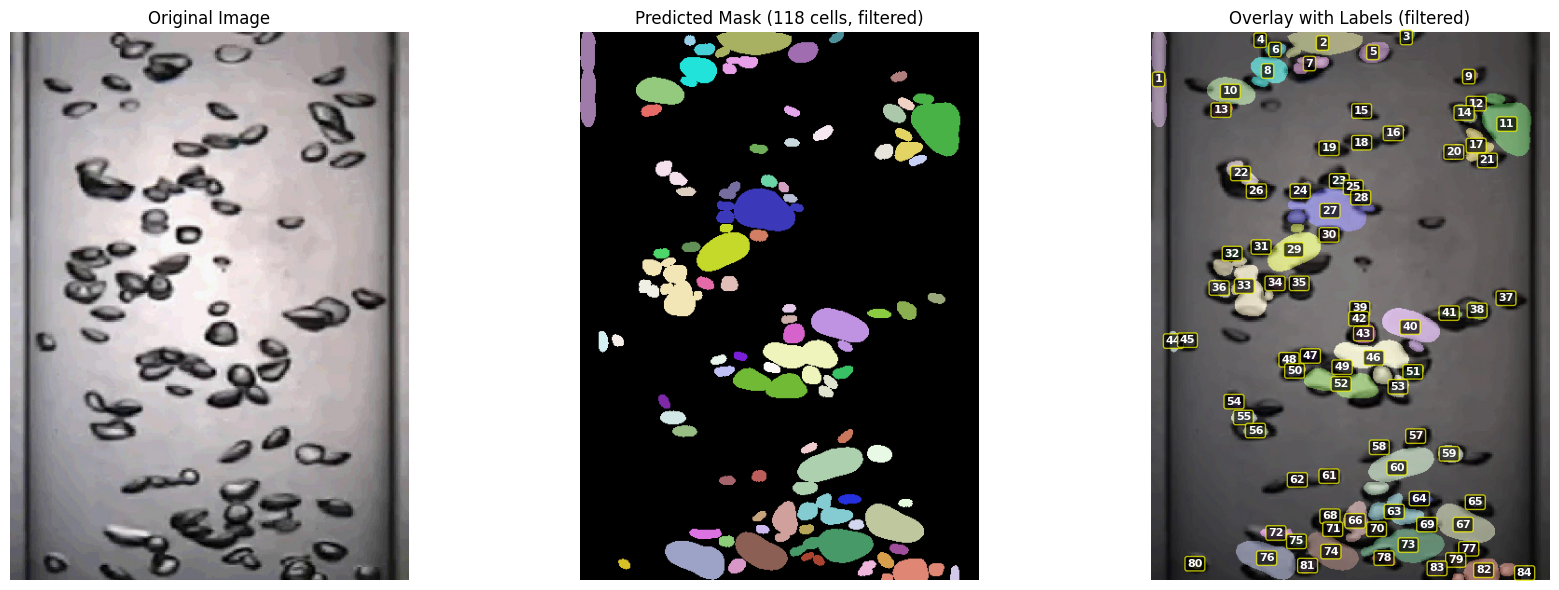


📊 frame_0011.png: 118 cells
   1 : 159.0 px²
   2 : 206.0 px²
   3 : 103.0 px²
   4 : 187.0 px²
   5 : 169.0 px²
   6 : 243.0 px²
   7 : 233.0 px²
   8 : 232.0 px²
   9 : 266.0 px²
   10 : 143.0 px²
   11 : 171.0 px²
   12 : 112.0 px²
   13 : 167.0 px²
   14 : 203.0 px²
   15 : 409.0 px²
   16 : 220.0 px²
   17 : 158.0 px²
   18 : 239.0 px²
   19 : 159.0 px²
   20 : 311.0 px²
   21 : 214.0 px²
   22 : 116.0 px²
   23 : 180.0 px²
   24 : 114.0 px²
   25 : 264.0 px²
   26 : 183.0 px²
   27 : 342.0 px²
   28 : 109.0 px²
   29 : 109.0 px²
   30 : 190.0 px²
   31 : 375.0 px²
   32 : 174.0 px²
   33 : 234.0 px²
   34 : 166.0 px²
   35 : 196.0 px²
   36 : 160.0 px²
   37 : 245.0 px²
   38 : 174.0 px²
   39 : 209.0 px²
   40 : 743.0 px²
   41 : 326.0 px²
   42 : 154.0 px²
   43 : 115.0 px²
   44 : 978.0 px²
   45 : 574.0 px²
   46 : 410.0 px²
   47 : 165.0 px²
   48 : 257.0 px²
   49 : 1693.0 px²
   50 : 134.0 px²
   51 : 343.0 px²
   52 : 109.0 px²
   53 : 246.0 px²
   54 : 326.0 px²
   55 :

In [105]:
# Load ảnh đầu tiên
frame_files = sorted(Path(FRAMES_DIR).glob("*.png"))
if len(frame_files) == 0:
    print(f"⚠️ Không tìm thấy file ảnh trong: {FRAMES_DIR}")
else:
    img_path = frame_files[10]
    print(f"📸 Xử lý: {img_path.name}\n")

    # Load và normalize ảnh
    img = np.array(Image.open(img_path))
    img_norm = normalize(img, 1, 99.8, axis=(0, 1))

    # Dự đoán
    labels, details = model.predict_instances(
        img_norm,
        n_tiles=model._guess_n_tiles(img_norm),
        prob_thresh=model.thresholds.prob,
        nms_thresh=model.thresholds.nms
    )

    # Tính diện tích và lọc bỏ cell quá lớn
    from skimage.measure import regionprops

    # Ngưỡng lọc - có thể điều chỉnh
    MAX_AREA = 2500  # pixels² - loại bỏ cell lớn hơn ngưỡng này
    MAX_AREA_RATIO = 0.15  # Loại bỏ cell chiếm > 15% diện tích ảnh

    img_area = img.shape[0] * img.shape[1]
    max_allowed_area = min(MAX_AREA, img_area * MAX_AREA_RATIO)

    regions = regionprops(labels)

    # Lọc bỏ các cell quá lớn
    filtered_labels = labels.copy()
    removed_count = 0

    for region in regions:
        area = region.area
        # Lọc theo diện tích tuyệt đối và tỷ lệ
        if area > max_allowed_area:
            # Xóa cell quá lớn
            filtered_labels[filtered_labels == region.label] = 0
            removed_count += 1

    # Đếm lại sau khi lọc
    regions_filtered = regionprops(filtered_labels)
    cell_areas = [region.area for region in regions_filtered]
    n_cells = len(cell_areas)

    # Tạo lại labels đã được lọc (relabel từ 1)
    from scipy.ndimage import label
    filtered_labels, _ = label(filtered_labels > 0)

    # Cập nhật lại regions và points sau khi lọc
    regions_filtered = regionprops(filtered_labels)
    filtered_points = [region.centroid for region in regions_filtered]  # (row, col) format
    filtered_points = [(int(p[0]), int(p[1])) for p in filtered_points]

    if removed_count > 0:
        print(f"   Đã lọc bỏ {removed_count} cell quá lớn (> {max_allowed_area:.0f} px² hoặc > {MAX_AREA_RATIO*100:.0f}% ảnh)")

    # Hiển thị visualization
    lbl_cmap = random_label_cmap()
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ảnh gốc
    axes[0].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Mask (sau khi lọc)
    axes[1].imshow(filtered_labels, cmap=lbl_cmap)
    axes[1].set_title(f'Predicted Mask ({n_cells} cells, filtered)')
    axes[1].axis('off')

    # Overlay với số thứ tự (sau khi lọc)
    axes[2].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axes[2].imshow(filtered_labels, cmap=lbl_cmap, alpha=0.5)
    axes[2].set_title('Overlay with Labels (filtered)')
    axes[2].axis('off')

    # Vẽ số thứ tự lên mỗi cell (sau khi lọc)
    if n_cells > 0:
        for idx, (point, region) in enumerate(zip(filtered_points, regions_filtered), 1):
            y, x = point[0], point[1]
            axes[2].text(x, y, f'{idx}',
                        ha='center', va='center',
                        fontsize=8, fontweight='bold',
                        color='white',
                        bbox=dict(boxstyle='round,pad=0.2',
                                 facecolor='black',
                                 alpha=0.7,
                                 edgecolor='yellow',
                                 linewidth=1))

    plt.tight_layout()
    plt.show()

    # Print diện tích
    print(f"\n📊 {img_path.name}: {n_cells} cells")
    for idx, area in enumerate(cell_areas, 1):
        print(f"   {idx} : {area} px²")


In [98]:
# Lưu thống kê chi tiết cho từng ảnh
detailed_stats = []
for result in results:
    detailed_stats.append({
        'filename': result['filename'],
        'n_cells': result['n_cells'],
        'avg_probability': float(np.mean(result['cell_probabilities'])) if result['n_cells'] > 0 else 0.0,
        'min_probability': float(np.min(result['cell_probabilities'])) if result['n_cells'] > 0 else 0.0,
        'max_probability': float(np.max(result['cell_probabilities'])) if result['n_cells'] > 0 else 0.0
    })

# Lưu vào file JSON
stats_path = os.path.join(OUTPUT_DIR, "statistics.json")
with open(stats_path, 'w', encoding='utf-8') as f:
    json.dump({
        'summary': summary_stats,
        'detailed': detailed_stats
    }, f, indent=2, ensure_ascii=False)

print(f"✅ Đã lưu thống kê vào: {stats_path}")




✅ Đã lưu thống kê vào: /content/drive/MyDrive/inference_results/statistics.json
